# **MALA algorithm**

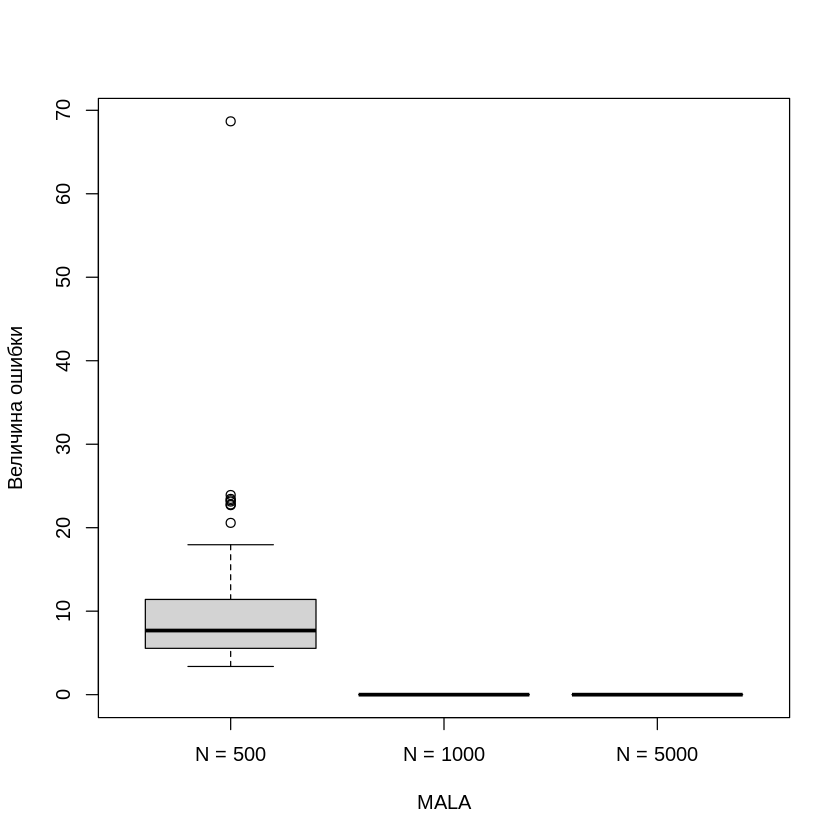

In [ ]:
library("MASS")
d = 2
r = 3
n = 500
M = 100

E = rep(0,M)
W = matrix(0,M,3)

#Тета_0 - фиксированные параметры
mu_0 = 0
mu_w_0 = 2
lambda_w_0 = 3
gamma_0 = 1
alpha_lambda = 1
beta_lambda = 1

t = 1
epsilon <-0.017

#Функция: логарифм функции правдоподобия
loglik <- function(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X) {

  loglik_1 = sum(y*(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2)))))
  loglik_0 = sum(log(1+exp(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2))))))
  loglik = loglik_1 - loglik_0
  return(loglik)
}

#Функция: логарифм априорного распределения для Theta_H
log_theta_H = function(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new) {

  log_lambda_w = dgamma(Beta_lambda_w_new, shape = alpha_lambda,rate = beta_lambda, log = TRUE)
  log_mu_w = dnorm(Beta_mu_w_new, mu_0, sqrt(1/(gamma_0*Beta_lambda_w_new)), log = TRUE)
  log_lambda_v = sum(dgamma(Beta_lambda_v_new , shape = alpha_lambda,rate = beta_lambda, log = TRUE))
  log_mu_v = sum(dnorm(Beta_mu_v_new, mu_0, sqrt(1/(gamma_0 * Beta_lambda_v_new)), log = TRUE))

  log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
  return(log_theta_H)
}

#Функция: логарифм априорного распределения для Theta
log_theta = function(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new){

  log_theta_0 = dnorm(Beta_Theta_0, mu_w_0, sqrt(1/lambda_w_0), log = TRUE)
  log_theta_w = sum(dnorm(Beta_Theta_w, Beta_mu_w_new, sqrt(1/Beta_lambda_w_new), log = TRUE))
  log_theta_v = sum(dnorm(Beta_v_matrix, Beta_mu_v_new, sqrt(1/Beta_lambda_v_new), log = TRUE))

  log_theta = log_theta_0 + log_theta_w + log_theta_v
  return(log_theta)
}

#Функция: градиент логарифма апостериорного распределения
logpost_grad_function <- function(X,Theta_0, Theta_w, Theta_v_matrix, y, lambda_w_0, mu_w_0, lambda_w_new, mu_w_new, lambda_v_new, mu_v_new,
                                  alpha_lambda, beta_lambda, gamma_0, mu_0){

  doudle_Sum = 0.5 * rowSums((X%*%Theta_v_matrix)^2 - (X^2)%*%(Theta_v_matrix^2))
  ratioexp_old=c(exp(Theta_0 + X%*%Theta_w+doudle_Sum)/(1+exp(Theta_0 + X%*%Theta_w+doudle_Sum)))

  sums_x <- matrix(apply(X, 2, function(q) apply(X, 2, function(o) sum((y-ratioexp_old)*q*o))), nrow = d, ncol = d)
  v_matrix = c(t(t(crossprod(Theta_v_matrix, sums_x)) - Theta_v_matrix * colSums((y-ratioexp_old)*X^2)))

  h <- matrix(c(rep(1, n), X), n, 1 + d)
  h_sum = colSums((y-ratioexp_old)*h)

  grad_loglik = c(h_sum, v_matrix, rep(0, 2+2*r))

  grad_log_theta = c(-lambda_w_0*(Theta_0 - mu_w_0), -lambda_w_new*(Theta_w-mu_w_new), -lambda_v_new*(Theta_v_matrix-mu_v_new),
                          -1/2*sum((Theta_w - mu_w_new)^2)+d/(2*lambda_w_new), lambda_w*sum(Theta_w - mu_w_new),
                            -1/2*sum((Theta_v_matrix - mu_v_new)^2)+d/(2*lambda_v_new),  lambda_v_new*sum(Theta_v_matrix - mu_v_new))

  grad_log_theta_H = c(rep(0, 1+d+d*r), (alpha_lambda-1)/lambda_w_new - beta_lambda + 1/(2*lambda_w_new) - gamma_0/2*(mu_w_new - mu_0)^2,
                               -gamma_0*lambda_w_new*(mu_w_new - mu_0), (alpha_lambda-1)/lambda_v_new - beta_lambda + 1/(2*lambda_v_new) - gamma_0/2*(mu_v_new - mu_0)^2,
                                -gamma_0*lambda_v_new*(mu_v_new - mu_0))

  logpost_grad_new = grad_loglik + grad_log_theta+grad_log_theta_H

  return(logpost_grad_new)
}

for (N in c(50)){
  for(m in 1:M){

    X = matrix(rnorm(d*n),n,d)

    #Параметры
    w_0 = rnorm(1, mu_w_0, sqrt(1/lambda_w_0))
    lambda_w = rgamma(1, shape = alpha_lambda, rate = beta_lambda)
    mu_w = rnorm(1, mu_0, sqrt(1/(gamma_0*lambda_w)))
    w = rnorm(d, mu_w, sqrt(1/lambda_w))
    lambda_v = rgamma(r, shape = alpha_lambda, rate = beta_lambda)
    mu_v = rnorm(r, mu_0, sqrt(1/(gamma_0*lambda_v)))
    v = matrix(rnorm((d*r), mu_v, sqrt(1/lambda_v)),d,r,byrow=TRUE)

    #Beta_teor
    Beta_teor = c(w_0, w, c(t(v)), lambda_w, mu_w, lambda_v, mu_v)

    sigma2 <- epsilon^2/((1+d+d*r+2+2*r)^(1 / 3))
    sigma <- sqrt(sigma2)

    doudle_Sum_teor = 0.5 * rowSums((X%*%v)^2 - (X^2)%*%(v^2))
    p = 1 /(1 + exp(-(w_0 + X %*%w + doudle_Sum_teor)))
    y = rbinom(n,1,p)
    j<-0

    mu_w_new = 0
    mu_v_new = rep(0, r)
    lambda_w_new = 1
    lambda_v_new = rep(1, r)

    Theta_0 = 0
    Theta_w = rep(0, d)
    Theta_v = rep(0, d*r)
    Beta = c(Theta_0, Theta_w, Theta_v, lambda_w_new, mu_w_new, lambda_v_new, mu_v_new)

    Theta_v_matrix = t(matrix(Theta_v, r, d))

    SaveResults<- matrix(0,N,1+d+d*r+2+2*r)
    S<-diag(1+d+d*r+2+2*r)
    S1 <- solve(S)

    #Градиент логарифма апостериорного распределения
    logpost_grad = logpost_grad_function(X, Theta_0, Theta_w, Theta_v_matrix, y, lambda_w_0, mu_w_0, lambda_w_new, mu_w_new,
                                     lambda_v_new, mu_v_new, alpha_lambda, beta_lambda, gamma_0, mu_0)


    #Логарифм функции правдоподобия для Beta
    loglik_Beta = loglik(Theta_0, Theta_w, Theta_v_matrix, y, X)
    #Логарифм априорного распределения для Theta_H для Beta
    log_theta_H_Beta = log_theta_H(lambda_w_new, alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
    #Логарифм априорного распределения для Theta для Beta
    log_theta_Beta = log_theta(Theta_0, mu_w_0, lambda_w_0, Theta_w, mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

    #Логарифм апостериорного распределения для Beta
    logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta


    for(i in 1:N){

      # Proposal distribution for beta
      Beta_new <-  Beta + sigma2/2*logpost_grad + sigma*rnorm(1+d+d*r+2+2*r)

      Beta_Theta_0 = Beta_new[1]
      Beta_Theta_w = Beta_new[2:(d+1)]
      Beta_Theta_v = Beta_new[(d+2):(d+1+d*r)]
      Beta_v_matrix = t(matrix(Beta_Theta_v, r, d))

      Beta_lambda_w_new = Beta_new[1+d+d*r+1]
      Beta_mu_w_new = Beta_new[1+d+d*r+2]
      Beta_lambda_v_new = Beta_new[(1+d+d*r+3):(1+d+d*r+2+r)]
      Beta_mu_v_new = Beta_new[(1+d+d*r+2+r+1):(1+d+d*r+2+2*r)]

       #Логарифм функции правдоподобия для Beta_new
      loglik_Beta_new = loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X)
      #Логарифм априорного распределения для Theta_H для Beta_new
      log_theta_H_Beta_new = log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new)
      #Логарифм априорного распределения для Theta для Beta_new
      log_theta_Beta_new = log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new)

      #Логарифм апостериорного распределения для Beta_new
      logpost_Beta_new = loglik_Beta_new + log_theta_H_Beta_new + log_theta_Beta_new


      #Градиент логарифма апостериорного распределения для Beta_new
      logpost_grad_new = logpost_grad_function(X, Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, lambda_w_0, mu_w_0, Beta_lambda_w_new,
                                         Beta_mu_w_new, Beta_lambda_v_new, Beta_mu_v_new, alpha_lambda, beta_lambda, gamma_0, mu_0)

      # Вспомогательные распределения
      qold <- -t(Beta - Beta_new - sigma2/2*logpost_grad_new)%*%S1%*%(Beta - Beta_new - sigma2/2*logpost_grad_new )/(2*sigma2)
      qnew <- -t(Beta_new - Beta - sigma2/2*logpost_grad)%*%S1%*%(Beta_new - Beta - sigma2/2*logpost_grad)/(2*sigma2)

      # # Metropolis ratio
      ratio <- (logpost_Beta_new - logpost_Beta + qold - qnew)
      # Accept/reject step
      if(log(runif(1)) < ratio)
      {
        logpost_Beta <- logpost_Beta_new
        logpost_grad <- logpost_grad_new
        Beta <- Beta_new
        j <- j+1
      }
      # Saving results
      SaveResults[i,] <- Beta
    }
    b_1 <- colMeans(SaveResults)
    E[m] = sqrt(sum((Beta_teor - b_1)^2))
  }
  W[,t] = E
  t<-t+1
}
boxplot(W, names = c("N = 500", "N = 1000", "N = 5000"), ylab = "Величина ошибки", xlab = "MALA")

# **MALA algorithm (небольшая размерность)**

In [ ]:
library("MASS")
d = 2
r = 3
n = 500
M = 10

E = rep(0,M)
W = matrix(0,M,3)

#Тета_0 - фиксированные параметры
mu_0 = 0
mu_w_0 = 2
lambda_w_0 = 3
gamma_0 = 1
alpha_lambda = 1
beta_lambda = 1

t = 1
epsilon <-0.017

#Функция: логарифм функции правдоподобия
loglik <- function(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X) {

  loglik_1 = sum(y*(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2)))))
  loglik_0 = sum(log(1+exp(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2))))))
  loglik = loglik_1 - loglik_0
  return(loglik)
}

#Функция: логарифм априорного распределения для Theta_H
log_theta_H = function(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new) {

  log_lambda_w = dgamma(Beta_lambda_w_new, shape = alpha_lambda,rate = beta_lambda, log = TRUE)
  log_mu_w = dnorm(Beta_mu_w_new, mu_0, sqrt(1/(gamma_0*Beta_lambda_w_new)), log = TRUE)
  log_lambda_v = sum(dgamma(Beta_lambda_v_new , shape = alpha_lambda,rate = beta_lambda, log = TRUE))
  log_mu_v = sum(dnorm(Beta_mu_v_new, mu_0, sqrt(1/(gamma_0 * Beta_lambda_v_new)), log = TRUE))

  log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
  return(log_theta_H)
}

#Функция: логарифм априорного распределения для Theta
log_theta = function(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new){

  log_theta_0 = dnorm(Beta_Theta_0, mu_w_0, sqrt(1/lambda_w_0), log = TRUE)
  log_theta_w = sum(dnorm(Beta_Theta_w, Beta_mu_w_new, sqrt(1/Beta_lambda_w_new), log = TRUE))
  log_theta_v = sum(dnorm(Beta_v_matrix, Beta_mu_v_new, sqrt(1/Beta_lambda_v_new), log = TRUE))

  log_theta = log_theta_0 + log_theta_w + log_theta_v
  return(log_theta)
}

#Функция: градиент логарифма апостериорного распределения
logpost_grad_function <- function(X,Theta_0, Theta_w, Theta_v_matrix, y, lambda_w_0, mu_w_0, lambda_w_new, mu_w_new, lambda_v_new, mu_v_new,
                                  alpha_lambda, beta_lambda, gamma_0, mu_0){

  doudle_Sum = 0.5 * rowSums((X%*%Theta_v_matrix)^2 - (X^2)%*%(Theta_v_matrix^2))
  ratioexp_old=c(exp(Theta_0 + X%*%Theta_w+doudle_Sum)/(1+exp(Theta_0 + X%*%Theta_w+doudle_Sum)))

  sums_x <- matrix(apply(X, 2, function(q) apply(X, 2, function(o) sum((y-ratioexp_old)*q*o))), nrow = d, ncol = d)
  v_matrix = c(t(t(crossprod(Theta_v_matrix, sums_x)) - Theta_v_matrix * colSums((y-ratioexp_old)*X^2)))

  h <- matrix(c(rep(1, n), X), n, 1 + d)
  h_sum = colSums((y-ratioexp_old)*h)

  grad_loglik = c(h_sum, v_matrix, rep(0, 2+2*r))

  grad_log_theta = c(-lambda_w_0*(Theta_0 - mu_w_0), -lambda_w_new*(Theta_w-mu_w_new), -lambda_v_new*(Theta_v_matrix-mu_v_new),
                          -1/2*sum((Theta_w - mu_w_new)^2)+d/(2*lambda_w_new), lambda_w*sum(Theta_w - mu_w_new),
                            -1/2*sum((Theta_v_matrix - mu_v_new)^2)+d/(2*lambda_v_new), lambda_v_new*sum(Theta_v_matrix - mu_v_new))

  grad_log_theta_H = c(rep(0, 1+d+d*r), (alpha_lambda-1)/lambda_w_new - beta_lambda + 1/(2*lambda_w_new) - gamma_0/2*(mu_w_new - mu_0)^2,
                               -gamma_0*lambda_w_new*(mu_w_new - mu_0), (alpha_lambda-1)/lambda_v_new - beta_lambda + 1/(2*lambda_v_new) - gamma_0/2*(mu_v_new - mu_0)^2,
                                -gamma_0*lambda_v_new*(mu_v_new - mu_0))

  logpost_grad_new = grad_loglik + grad_log_theta+grad_log_theta_H

  return(logpost_grad_new)
}

for (N in c(5)){
  for(m in 1:M){

    X = matrix(rnorm(d*n),n,d)

    #Параметры
    w_0 = rnorm(1, mu_w_0, sqrt(1/lambda_w_0))
    lambda_w = rgamma(1, shape = alpha_lambda, rate = beta_lambda)
    mu_w = rnorm(1, mu_0, sqrt(1/(gamma_0*lambda_w)))
    w = rnorm(d, mu_w, sqrt(1/lambda_w))
    lambda_v = rgamma(r, shape = alpha_lambda, rate = beta_lambda)
    mu_v = rnorm(r, mu_0, sqrt(1/(gamma_0*lambda_v)))
    v = matrix(rnorm((d*r), mu_v, sqrt(1/lambda_v)),d,r,byrow=TRUE)

    #Beta_teor
    Beta_teor = c(w_0, w, c(t(v)), lambda_w, mu_w, lambda_v, mu_v)

    sigma2 <- epsilon^2/((1+d+d*r+2+2*r)^(1 / 3))
    sigma <- sqrt(sigma2)

    doudle_Sum_teor = 0.5 * rowSums((X%*%v)^2 - (X^2)%*%(v^2))
    p = 1 /(1 + exp(-(w_0 + X %*%w + doudle_Sum_teor)))
    y = rbinom(n,1,p)
    j<-0

    mu_w_new = 0
    mu_v_new = rep(0, r)
    lambda_w_new = 1
    lambda_v_new = rep(1, r)

    Theta_0 = 0
    Theta_w = rep(0, d)
    Theta_v = rep(0, d*r)
    Beta = c(Theta_0, Theta_w, Theta_v, lambda_w_new, mu_w_new, lambda_v_new, mu_v_new)

    Theta_v_matrix = t(matrix(Theta_v, r, d))

    SaveResults<- matrix(0,N,1+d+d*r+2+2*r)
    S<-diag(1+d+d*r+2+2*r)
    S1 <- solve(S)

    #Градиент логарифма апостериорного распределения
    logpost_grad = logpost_grad_function(X, Theta_0, Theta_w, Theta_v_matrix, y, lambda_w_0, mu_w_0, lambda_w_new, mu_w_new,
                                     lambda_v_new, mu_v_new, alpha_lambda, beta_lambda, gamma_0, mu_0)


    #Логарифм функции правдоподобия для Beta
    loglik_Beta = loglik(Theta_0, Theta_w, Theta_v_matrix, y, X)
    #Логарифм априорного распределения для Theta_H для Beta
    log_theta_H_Beta = log_theta_H(lambda_w_new, alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
    #Логарифм априорного распределения для Theta для Beta
    log_theta_Beta = log_theta(Theta_0, mu_w_0, lambda_w_0, Theta_w, mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

    #Логарифм апостериорного распределения для Beta
    logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta


    for(i in 1:N){

      # Proposal distribution for beta
      Beta_new <-  Beta + sigma2/2*logpost_grad + sigma*rnorm(1+d+d*r+2+2*r)

      Beta_Theta_0 = Beta_new[1]
      Beta_Theta_w = Beta_new[2:(d+1)]
      Beta_Theta_v = Beta_new[(d+2):(d+1+d*r)]
      Beta_v_matrix = t(matrix(Beta_Theta_v, r, d))

      Beta_lambda_w_new = Beta_new[1+d+d*r+1]
      Beta_mu_w_new = Beta_new[1+d+d*r+2]
      Beta_lambda_v_new = Beta_new[(1+d+d*r+3):(1+d+d*r+2+r)]
      Beta_mu_v_new = Beta_new[(1+d+d*r+2+r+1):(1+d+d*r+2+2*r)]

       #Логарифм функции правдоподобия для Beta_new
      loglik_Beta_new = loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X)
      #Логарифм априорного распределения для Theta_H для Beta_new
      log_theta_H_Beta_new = log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new)
      #Логарифм априорного распределения для Theta для Beta_new
      log_theta_Beta_new = log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new)

      #Логарифм апостериорного распределения для Beta_new
      logpost_Beta_new = loglik_Beta_new + log_theta_H_Beta_new + log_theta_Beta_new


      #Градиент логарифма апостериорного распределения для Beta_new
      logpost_grad_new = logpost_grad_function(X, Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, lambda_w_0, mu_w_0, Beta_lambda_w_new,
                                         Beta_mu_w_new, Beta_lambda_v_new, Beta_mu_v_new, alpha_lambda, beta_lambda, gamma_0, mu_0)

      # Вспомогательные распределения
      qold <- -t(Beta - Beta_new - sigma2/2*logpost_grad_new)%*%S1%*%(Beta - Beta_new - sigma2/2*logpost_grad_new )/(2*sigma2)
      qnew <- -t(Beta_new - Beta - sigma2/2*logpost_grad)%*%S1%*%(Beta_new - Beta - sigma2/2*logpost_grad)/(2*sigma2)

      # # Metropolis ratio
      ratio <- (logpost_Beta_new - logpost_Beta + qold - qnew)
      # Accept/reject step
      if(log(runif(1)) < ratio)
      {
        logpost_Beta <- logpost_Beta_new
        logpost_grad <- logpost_grad_new
        Beta <- Beta_new
        j <- j+1
      }
      # Saving results
      SaveResults[i,] <- Beta
    }
    b_1 <- colMeans(SaveResults)
    E[m] = sqrt(sum((Beta_teor - b_1)^2))
  }
  W[,t] = E
  t<-t+1
}
SaveResults
cat("Среднее по матрице", b_1, "\n")

-0.005046413,-0.01465302,0.011695545,0.010543331,-0.001213896,-0.019240881,-0.010472897,0.002057434,-0.007835563,1.0110315,-0.002938385,0.9961246,0.9896928,0.9834632,-0.0002681264,0.0003322066,0.0113589853
0.002937401,-0.02232054,-0.017216257,0.029622982,0.001962079,-0.016358856,0.003124450,0.009671850,-0.025331097,0.9967981,-0.014185941,0.9940434,0.9881313,0.9872433,-0.0104634485,-0.0021463110,0.0006162415
0.011341178,-0.03136194,-0.020681385,0.030891744,0.010998660,-0.007134029,-0.007801928,0.017374659,-0.042055609,1.0065757,-0.007000343,0.9818492,0.9939386,0.9840894,-0.0003117748,-0.0067651133,-0.0100634104
0.020404993,-0.04491746,-0.013633695,0.022613792,0.014772858,0.002868077,-0.004119206,0.002484257,-0.048439007,0.9943919,0.005574065,0.9872117,0.9875595,0.9818072,-0.0047446287,0.0045936285,-0.0207693867
0.032800981,-0.03606305,-0.003945338,0.008605122,0.020917444,0.016351707,-0.002025403,0.015067419,-0.048192088,1.0127730,0.020012782,0.9934131,0.9788427,0.9588155,-0.0076539930,-0.0121087870,-0.0096689029


Среднее по матрице 0.01248763 -0.0298632 -0.008756226 0.02045539 0.009487429 -0.004702796 -0.004258997 0.009331124 -0.03437067 1.004314 0.0002924357 0.9905284 0.987633 0.9790837 -0.004688394 -0.003218875 -0.005705295 


# **Datasets**

In [ ]:
install.packages("PRROC")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



**Pima Indians Diabetes Dataset**

[1] 0.6501349

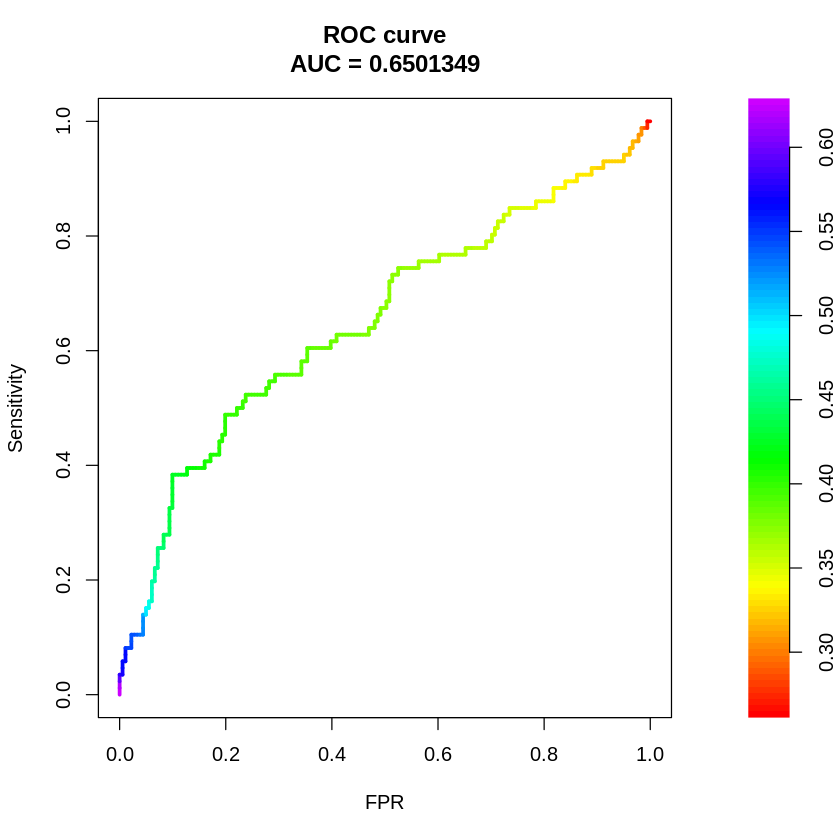

In [ ]:
library("MASS")
library("PRROC")
library(data.table)

data <- fread("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv", header=TRUE)
data = as.matrix(data)

X = data[1:500,1:8]
y = data[1:500,9]

d = ncol(X)
n = 500
r = 3
N = 100

#Тета_0 - фиксированные параметры
mu_0 = 0
mu_w_0 = 2
lambda_w_0 = 3
gamma_0 = 1
alpha_lambda = 1
beta_lambda = 1

epsilon <-0.001

sigma2 <- epsilon^2/((1+d+d*r+2+2*r)^(1 / 3))
sigma <- sqrt(sigma2)

SaveResults<- matrix(0,N,1+d+d*r+2+2*r)
S<-diag(1+d+d*r+2+2*r)
S1 <- solve(S)

mu_w_new = 0
mu_v_new = rep(0, r)
lambda_w_new = 1
lambda_v_new = rep(1, r)

Theta_0 = 0
Theta_w = rep(0, d)
Theta_v = rep(0, d*r)
Beta = c(Theta_0, Theta_w, Theta_v, lambda_w_new, mu_w_new, lambda_v_new, mu_v_new)

Theta_v_matrix = t(matrix(Theta_v, r, d))

#Функция: логарифм функции правдоподобия
loglik <- function(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X) {

  loglik_1 = sum(y*(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2)))))
  loglik_0 = sum(log(1+exp(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2))))))
  loglik = loglik_1 - loglik_0
  return(loglik)
}

#Функция: логарифм априорного распределения для Theta_H
log_theta_H = function(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new) {

  log_lambda_w = dgamma(Beta_lambda_w_new, shape = alpha_lambda,rate = beta_lambda, log = TRUE)
  log_mu_w = dnorm(Beta_mu_w_new, mu_0, sqrt(1/(gamma_0*Beta_lambda_w_new)), log = TRUE)
  log_lambda_v = sum(dgamma(Beta_lambda_v_new , shape = alpha_lambda,rate = beta_lambda, log = TRUE))
  log_mu_v = sum(dnorm(Beta_mu_v_new, mu_0, sqrt(1/(gamma_0 * Beta_lambda_v_new)), log = TRUE))

  log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
  return(log_theta_H)
}

#Функция: логарифм априорного распределения для Theta
log_theta = function(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new){

  log_theta_0 = dnorm(Beta_Theta_0, mu_w_0, sqrt(1/lambda_w_0), log = TRUE)
  log_theta_w = sum(dnorm(Beta_Theta_w, Beta_mu_w_new, sqrt(1/Beta_lambda_w_new), log = TRUE))
  log_theta_v = sum(dnorm(Beta_v_matrix, Beta_mu_v_new, sqrt(1/Beta_lambda_v_new), log = TRUE))

  log_theta = log_theta_0 + log_theta_w + log_theta_v
  return(log_theta)
}

#Функция: градиент логарифма апостериорного распределения
logpost_grad_function <- function(X,Theta_0, Theta_w, Theta_v_matrix, y, lambda_w_0, mu_w_0, lambda_w_new, mu_w_new, lambda_v_new, mu_v_new,
                                  alpha_lambda, beta_lambda, gamma_0, mu_0){

  doudle_Sum = 0.5 * rowSums((X%*%Theta_v_matrix)^2 - (X^2)%*%(Theta_v_matrix^2))
  ratioexp_old=c(exp(Theta_0 + X%*%Theta_w+doudle_Sum)/(1+exp(Theta_0 + X%*%Theta_w+doudle_Sum)))

  sums_x <- matrix(apply(X, 2, function(q) apply(X, 2, function(o) sum((y-ratioexp_old)*q*o))), nrow = d, ncol = d)

  v_matrix = c(t(t(crossprod(Theta_v_matrix, sums_x)) - Theta_v_matrix * colSums((y-ratioexp_old)*X^2)))

  h <- matrix(c(rep(1, n), X), n, 1 + d)
  h_sum = colSums((y-ratioexp_old)*h)

  grad_loglik = c(h_sum, v_matrix, rep(0, 2+2*r))

  grad_log_theta = c(-lambda_w_0*(Theta_0 - mu_w_0), -lambda_w_new*(Theta_w-mu_w_new), -lambda_v_new*(Theta_v_matrix-mu_v_new),
                          -1/2*sum((Theta_w - mu_w_new)^2)+d/(2*lambda_w_new), lambda_w_new*sum(Theta_w - mu_w_new),
                            -1/2*sum((Theta_v_matrix - mu_v_new)^2)+d/(2*lambda_v_new),  lambda_v_new*sum(Theta_v_matrix - mu_v_new))

  grad_log_theta_H = c(rep(0, 1+d+d*r), (alpha_lambda-1)/lambda_w_new - beta_lambda + 1/(2*lambda_w_new) - gamma_0/2*(mu_w_new - mu_0)^2,
                               -gamma_0*lambda_w_new*(mu_w_new - mu_0), (alpha_lambda-1)/lambda_v_new - beta_lambda + 1/(2*lambda_v_new) - gamma_0/2*(mu_v_new - mu_0)^2,
                                -gamma_0*lambda_v_new*(mu_v_new - mu_0))

  logpost_grad_new = grad_loglik + grad_log_theta+grad_log_theta_H

  return(logpost_grad_new)
}

auroc <- function(score, bool) {
  n1 <- sum(!bool)
  n2 <- sum(bool)
  U  <- sum(rank(score)[!bool]) - n1 * (n1 + 1) / 2
  return(1 - U / n1 / n2)
}

#Градиент логарифма апостериорного распределения
logpost_grad = logpost_grad_function(X, Theta_0, Theta_w, Theta_v_matrix, y, lambda_w_0, mu_w_0, lambda_w_new, mu_w_new,
                                  lambda_v_new, mu_v_new, alpha_lambda, beta_lambda, gamma_0, mu_0)

#Логарифм функции правдоподобия для Beta
loglik_Beta = loglik(Theta_0, Theta_w, Theta_v_matrix, y, X)
#Логарифм априорного распределения для Theta_H для Beta
log_theta_H_Beta = log_theta_H(lambda_w_new, alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
#Логарифм априорного распределения для Theta для Beta
log_theta_Beta = log_theta(Theta_0, mu_w_0, lambda_w_0, Theta_w, mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

#Логарифм апостериорного распределения для Beta
logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta


for(i in 1:N){

  # Proposal distribution for beta
  Beta_new <-  Beta + sigma2/2*logpost_grad + sigma*rnorm(1+d+d*r+2+2*r)

  Beta_Theta_0 = Beta_new[1]
  Beta_Theta_w = Beta_new[2:(d+1)]
  Beta_Theta_v = Beta_new[(d+2):(d+1+d*r)]
  Beta_v_matrix = t(matrix(Beta_Theta_v, r, d))

  Beta_lambda_w_new = Beta_new[1+d+d*r+1]
  Beta_mu_w_new = Beta_new[1+d+d*r+2]
  Beta_lambda_v_new = Beta_new[(1+d+d*r+3):(1+d+d*r+2+r)]
  Beta_mu_v_new = Beta_new[(1+d+d*r+2+r+1):(1+d+d*r+2+2*r)]

    #Логарифм функции правдоподобия для Beta_new
  loglik_Beta_new = loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X)
  #Логарифм априорного распределения для Theta_H для Beta_new
  log_theta_H_Beta_new = log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new)
  #Логарифм априорного распределения для Theta для Beta_new
  log_theta_Beta_new = log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new)

  #Логарифм апостериорного распределения для Beta_new
  logpost_Beta_new = loglik_Beta_new + log_theta_H_Beta_new + log_theta_Beta_new


  #Градиент логарифма апостериорного распределения для Beta_new
  logpost_grad_new = logpost_grad_function(X, Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, lambda_w_0, mu_w_0, Beta_lambda_w_new,
                                      Beta_mu_w_new, Beta_lambda_v_new, Beta_mu_v_new, alpha_lambda, beta_lambda, gamma_0, mu_0)

  # Вспомогательные распределения
  qold <- -t(Beta - Beta_new - sigma2/2*logpost_grad_new)%*%S1%*%(Beta - Beta_new - sigma2/2*logpost_grad_new )/(2*sigma2)
  qnew <- -t(Beta_new - Beta - sigma2/2*logpost_grad)%*%S1%*%(Beta_new - Beta - sigma2/2*logpost_grad)/(2*sigma2)

  # # Metropolis ratio
  ratio <- (logpost_Beta_new - logpost_Beta + qold - qnew)

  # Accept/reject step
  if(log(runif(1)) < ratio)
  {
    logpost_Beta <- logpost_Beta_new
    logpost_grad <- logpost_grad_new
    Beta <- Beta_new
  }
  # Saving results
  SaveResults[i,] <- Beta
}

b_1 <- colMeans(SaveResults)
V = matrix(b_1[(d+2):(d+1+d*r)],d,r,byrow=TRUE)

X1 = data[501:767,1:8]
y1 = data[501:767,9]
D = 0.5 * rowSums((X1%*%V)^2 - (X1^2)%*%(V^2))
prob = 1 /(1 + exp(-(b_1[1] + X1 %*%b_1[2:(d+1)] + D)))

auroc(prob,y1)
PRROC_obj <- roc.curve(scores.class0 = prob, weights.class0=y1,
                       curve=TRUE)
plot(PRROC_obj)

**Sonar Dataset**

[1] 0.639011

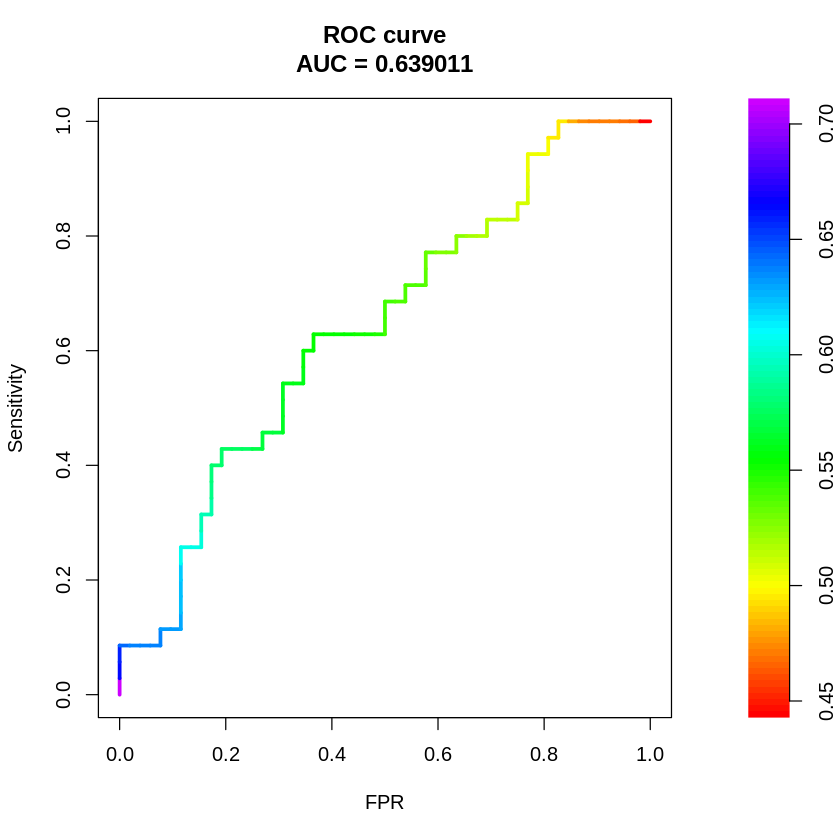

In [ ]:
library("MASS")
library("PRROC")
library(data.table)

data = fread("https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data", header=TRUE)
ind = sample(1:207)
data = data[ind,]

n = 120
r = 2
N = 100

X = data[1:n,1:60]
X = as.matrix(X)

y = (data[1:n,61]=='R') *1
y <- as.vector(y)
d = ncol(X)


#Тета_0 - фиксированные параметры
mu_0 = 0
mu_w_0 = 2
lambda_w_0 = 3
gamma_0 = 1
alpha_lambda = 1
beta_lambda = 1

epsilon <-0.09

sigma2 <- epsilon^2/((1+d+d*r+2+2*r)^(1 / 3))
sigma <- sqrt(sigma2)

SaveResults<- matrix(0,N,1+d+d*r+2+2*r)
S<-diag(1+d+d*r+2+2*r)
S1 <- solve(S)

mu_w_new = 0
mu_v_new = rep(0, r)
lambda_w_new = 1
lambda_v_new = rep(1, r)

Theta_0 = 0
Theta_w = rep(0, d)
Theta_v = rep(0, d*r)
Beta = c(Theta_0, Theta_w, Theta_v, lambda_w_new, mu_w_new, lambda_v_new, mu_v_new)

Theta_v_matrix = t(matrix(Theta_v, r, d))

#Функция: логарифм функции правдоподобия
loglik <- function(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X) {

  loglik_1 = sum(y*(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2)))))
  loglik_0 = sum(log(1+exp(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2))))))
  loglik = loglik_1 - loglik_0
  return(loglik)
}

#Функция: логарифм априорного распределения для Theta_H
log_theta_H = function(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new) {

  log_lambda_w = dgamma(Beta_lambda_w_new, shape = alpha_lambda,rate = beta_lambda, log = TRUE)
  log_mu_w = dnorm(Beta_mu_w_new, mu_0, sqrt(1/(gamma_0*Beta_lambda_w_new)), log = TRUE)
  log_lambda_v = sum(dgamma(Beta_lambda_v_new , shape = alpha_lambda,rate = beta_lambda, log = TRUE))
  log_mu_v = sum(dnorm(Beta_mu_v_new, mu_0, sqrt(1/(gamma_0 * Beta_lambda_v_new)), log = TRUE))

  log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
  return(log_theta_H)
}

#Функция: логарифм априорного распределения для Theta
log_theta = function(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new){

  log_theta_0 = dnorm(Beta_Theta_0, mu_w_0, sqrt(1/lambda_w_0), log = TRUE)
  log_theta_w = sum(dnorm(Beta_Theta_w, Beta_mu_w_new, sqrt(1/Beta_lambda_w_new), log = TRUE))
  log_theta_v = sum(dnorm(Beta_v_matrix, Beta_mu_v_new, sqrt(1/Beta_lambda_v_new), log = TRUE))

  log_theta = log_theta_0 + log_theta_w + log_theta_v
  return(log_theta)
}

#Функция: градиент логарифма апостериорного распределения
logpost_grad_function <- function(X,Theta_0, Theta_w, Theta_v_matrix, y, lambda_w_0, mu_w_0, lambda_w_new, mu_w_new, lambda_v_new, mu_v_new,
                                  alpha_lambda, beta_lambda, gamma_0, mu_0){

  doudle_Sum = 0.5 * rowSums((X%*%Theta_v_matrix)^2 - (X^2)%*%(Theta_v_matrix^2))
  ratioexp_old=c(exp(Theta_0 + X%*%Theta_w+doudle_Sum)/(1+exp(Theta_0 + X%*%Theta_w+doudle_Sum)))

  sums_x <- matrix(apply(X, 2, function(q) apply(X, 2, function(o) sum((y-ratioexp_old)*q*o))), nrow = d, ncol = d)

  v_matrix = c(t(t(crossprod(Theta_v_matrix, sums_x)) - Theta_v_matrix * colSums((y-ratioexp_old)*X^2)))

  h <- matrix(c(rep(1, n), X), n, 1 + d)
  h_sum = colSums((y-ratioexp_old)*h)

  grad_loglik = c(h_sum, v_matrix, rep(0, 2+2*r))

  grad_log_theta = c(-lambda_w_0*(Theta_0 - mu_w_0), -lambda_w_new*(Theta_w-mu_w_new), -lambda_v_new*(Theta_v_matrix-mu_v_new),
                          -1/2*sum((Theta_w - mu_w_new)^2)+d/(2*lambda_w_new), lambda_w_new*sum(Theta_w - mu_w_new),
                            -1/2*sum((Theta_v_matrix - mu_v_new)^2)+d/(2*lambda_v_new),  lambda_v_new*sum(Theta_v_matrix - mu_v_new))

  grad_log_theta_H = c(rep(0, 1+d+d*r), (alpha_lambda-1)/lambda_w_new - beta_lambda + 1/(2*lambda_w_new) - gamma_0/2*(mu_w_new - mu_0)^2,
                               -gamma_0*lambda_w_new*(mu_w_new - mu_0), (alpha_lambda-1)/lambda_v_new - beta_lambda + 1/(2*lambda_v_new) - gamma_0/2*(mu_v_new - mu_0)^2,
                                -gamma_0*lambda_v_new*(mu_v_new - mu_0))

  logpost_grad_new = grad_loglik + grad_log_theta+grad_log_theta_H

  return(logpost_grad_new)
}

auroc <- function(score, bool) {
  n1 <- sum(!bool)
  n2 <- sum(bool)
  U  <- sum(rank(score)[!bool]) - n1 * (n1 + 1) / 2
  return(1 - U / n1 / n2)
}

#Градиент логарифма апостериорного распределения
logpost_grad = logpost_grad_function(X, Theta_0, Theta_w, Theta_v_matrix, y, lambda_w_0, mu_w_0, lambda_w_new, mu_w_new,
                                  lambda_v_new, mu_v_new, alpha_lambda, beta_lambda, gamma_0, mu_0)


#Логарифм функции правдоподобия для Beta
loglik_Beta = loglik(Theta_0, Theta_w, Theta_v_matrix, y, X)
#Логарифм априорного распределения для Theta_H для Beta
log_theta_H_Beta = log_theta_H(lambda_w_new, alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
#Логарифм априорного распределения для Theta для Beta
log_theta_Beta = log_theta(Theta_0, mu_w_0, lambda_w_0, Theta_w, mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

#Логарифм апостериорного распределения для Beta
logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta

for(i in 1:N){

  # Proposal distribution for beta
  Beta_new <-  Beta + sigma2/2*logpost_grad + sigma*rnorm(1+d+d*r+2+2*r)

  Beta_Theta_0 = Beta_new[1]
  Beta_Theta_w = Beta_new[2:(d+1)]
  Beta_Theta_v = Beta_new[(d+2):(d+1+d*r)]
  Beta_v_matrix = t(matrix(Beta_Theta_v, r, d))

  Beta_lambda_w_new = Beta_new[1+d+d*r+1]
  Beta_mu_w_new = Beta_new[1+d+d*r+2]
  Beta_lambda_v_new = Beta_new[(1+d+d*r+3):(1+d+d*r+2+r)]
  Beta_mu_v_new = Beta_new[(1+d+d*r+2+r+1):(1+d+d*r+2+2*r)]

    #Логарифм функции правдоподобия для Beta_new
  loglik_Beta_new = loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X)
  #Логарифм априорного распределения для Theta_H для Beta_new
  log_theta_H_Beta_new = log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new)
  #Логарифм априорного распределения для Theta для Beta_new
  log_theta_Beta_new = log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new)

  #Логарифм апостериорного распределения для Beta_new
  logpost_Beta_new = loglik_Beta_new + log_theta_H_Beta_new + log_theta_Beta_new


  #Градиент логарифма апостериорного распределения для Beta_new
  logpost_grad_new = logpost_grad_function(X, Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, lambda_w_0, mu_w_0, Beta_lambda_w_new,
                                      Beta_mu_w_new, Beta_lambda_v_new, Beta_mu_v_new, alpha_lambda, beta_lambda, gamma_0, mu_0)

  # Вспомогательные распределения
  qold <- -t(Beta - Beta_new - sigma2/2*logpost_grad_new)%*%S1%*%(Beta - Beta_new - sigma2/2*logpost_grad_new )/(2*sigma2)
  qnew <- -t(Beta_new - Beta - sigma2/2*logpost_grad)%*%S1%*%(Beta_new - Beta - sigma2/2*logpost_grad)/(2*sigma2)

  # # Metropolis ratio
  ratio <- (logpost_Beta_new - logpost_Beta + qold - qnew)

  # Accept/reject step
  if(log(runif(1)) < ratio)
  {
    logpost_Beta <- logpost_Beta_new
    logpost_grad <- logpost_grad_new
    Beta <- Beta_new
  }
  # Saving results
  SaveResults[i,] <- Beta
}

b_1 <- colMeans(SaveResults)
V = matrix(b_1[(d+2):(d+1+d*r)],d,r,byrow=TRUE)

X1 = data[121:207,1:60]
X1 =as.matrix(X1)
y1 = (data[121:207,61]=='R')*1

D = 0.5 * rowSums((X1%*%V)^2 - (X1^2)%*%(V^2))
prob = 1 /(1 + exp(-(b_1[1] + X1 %*%b_1[2:(d+1)] + D)))
auroc(prob,y1)

PRROC_obj <- roc.curve(scores.class0 = prob, weights.class0=y1,
                       curve=TRUE)
plot(PRROC_obj)

**Australian Credit Approval DataSet**

[1] 0.6883807

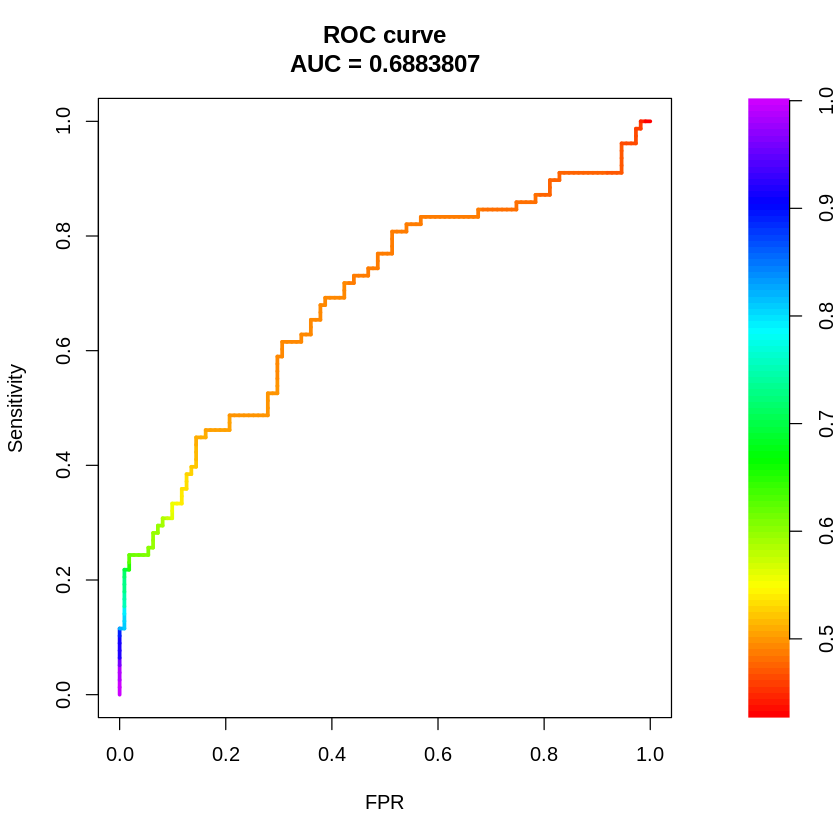

In [ ]:
library("MASS")
library("PRROC")
library(data.table)

data = fread("https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/australian/australian.dat", header = TRUE)
data = as.matrix(na.omit(data))

n = 500
y = data[1:n,15]
X = data[1:n,1:14]

d = ncol(X)

r = 3
N = 100


#Тета_0 - фиксированные параметры
mu_0 = 0
mu_w_0 = 2
lambda_w_0 = 3
gamma_0 = 1
alpha_lambda = 1
beta_lambda = 1

epsilon <-0.0001

sigma2 <- epsilon^2/((1+d+d*r+2+2*r)^(1 / 3))
sigma <- sqrt(sigma2)

SaveResults<- matrix(0,N,1+d+d*r+2+2*r)
S<-diag(1+d+d*r+2+2*r)
S1 <- solve(S)

mu_w_new = 0
mu_v_new = rep(0, r)
lambda_w_new = 1
lambda_v_new = rep(1, r)

Theta_0 = 0
Theta_w = rep(0, d)
Theta_v = rep(0, d*r)
Beta = c(Theta_0, Theta_w, Theta_v, lambda_w_new, mu_w_new, lambda_v_new, mu_v_new)

Theta_v_matrix = t(matrix(Theta_v, r, d))

#Функция: логарифм функции правдоподобия
loglik <- function(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X) {

  loglik_1 = sum(y*(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2)))))
  loglik_0 = sum(log(1+exp(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2))))))
  loglik = loglik_1 - loglik_0
  return(loglik)
}

#Функция: логарифм априорного распределения для Theta_H
log_theta_H = function(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new) {

  log_lambda_w = dgamma(Beta_lambda_w_new, shape = alpha_lambda,rate = beta_lambda, log = TRUE)
  log_mu_w = dnorm(Beta_mu_w_new, mu_0, sqrt(1/(gamma_0*Beta_lambda_w_new)), log = TRUE)
  log_lambda_v = sum(dgamma(Beta_lambda_v_new , shape = alpha_lambda,rate = beta_lambda, log = TRUE))
  log_mu_v = sum(dnorm(Beta_mu_v_new, mu_0, sqrt(1/(gamma_0 * Beta_lambda_v_new)), log = TRUE))

  log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
  return(log_theta_H)
}

#Функция: логарифм априорного распределения для Theta
log_theta = function(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new){

  log_theta_0 = dnorm(Beta_Theta_0, mu_w_0, sqrt(1/lambda_w_0), log = TRUE)
  log_theta_w = sum(dnorm(Beta_Theta_w, Beta_mu_w_new, sqrt(1/Beta_lambda_w_new), log = TRUE))
  log_theta_v = sum(dnorm(Beta_v_matrix, Beta_mu_v_new, sqrt(1/Beta_lambda_v_new), log = TRUE))

  log_theta = log_theta_0 + log_theta_w + log_theta_v
  return(log_theta)
}

#Функция: градиент логарифма апостериорного распределения
logpost_grad_function <- function(X,Theta_0, Theta_w, Theta_v_matrix, y, lambda_w_0, mu_w_0, lambda_w_new, mu_w_new, lambda_v_new, mu_v_new,
                                  alpha_lambda, beta_lambda, gamma_0, mu_0){

  doudle_Sum = 0.5 * rowSums((X%*%Theta_v_matrix)^2 - (X^2)%*%(Theta_v_matrix^2))
  ratioexp_old=c(exp(Theta_0 + X%*%Theta_w+doudle_Sum)/(1+exp(Theta_0 + X%*%Theta_w+doudle_Sum)))

  sums_x <- matrix(apply(X, 2, function(q) apply(X, 2, function(o) sum((y-ratioexp_old)*q*o))), nrow = d, ncol = d)

  v_matrix = c(t(t(crossprod(Theta_v_matrix, sums_x)) - Theta_v_matrix * colSums((y-ratioexp_old)*X^2)))

  h <- matrix(c(rep(1, n), X), n, 1 + d)
  h_sum = colSums((y-ratioexp_old)*h)

  grad_loglik = c(h_sum, v_matrix, rep(0, 2+2*r))

  grad_log_theta = c(-lambda_w_0*(Theta_0 - mu_w_0), -lambda_w_new*(Theta_w-mu_w_new), -lambda_v_new*(Theta_v_matrix-mu_v_new),
                          -1/2*sum((Theta_w - mu_w_new)^2)+d/(2*lambda_w_new), lambda_w_new*sum(Theta_w - mu_w_new),
                            -1/2*sum((Theta_v_matrix - mu_v_new)^2)+d/(2*lambda_v_new),  lambda_v_new*sum(Theta_v_matrix - mu_v_new))

  grad_log_theta_H = c(rep(0, 1+d+d*r), (alpha_lambda-1)/lambda_w_new - beta_lambda + 1/(2*lambda_w_new) - gamma_0/2*(mu_w_new - mu_0)^2,
                               -gamma_0*lambda_w_new*(mu_w_new - mu_0), (alpha_lambda-1)/lambda_v_new - beta_lambda + 1/(2*lambda_v_new) - gamma_0/2*(mu_v_new - mu_0)^2,
                                -gamma_0*lambda_v_new*(mu_v_new - mu_0))

  logpost_grad_new = grad_loglik + grad_log_theta+grad_log_theta_H

  return(logpost_grad_new)
}

auroc <- function(score, bool) {
  n1 <- sum(!bool)
  n2 <- sum(bool)
  U  <- sum(rank(score)[!bool]) - n1 * (n1 + 1) / 2
  return(1 - U / n1 / n2)
}

#Градиент логарифма апостериорного распределения
logpost_grad = logpost_grad_function(X, Theta_0, Theta_w, Theta_v_matrix, y, lambda_w_0, mu_w_0, lambda_w_new, mu_w_new,
                                  lambda_v_new, mu_v_new, alpha_lambda, beta_lambda, gamma_0, mu_0)


#Логарифм функции правдоподобия для Beta
loglik_Beta = loglik(Theta_0, Theta_w, Theta_v_matrix, y, X)
# print(loglik_Beta)
#Логарифм априорного распределения для Theta_H для Beta
log_theta_H_Beta = log_theta_H(lambda_w_new, alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
#Логарифм априорного распределения для Theta для Beta
log_theta_Beta = log_theta(Theta_0, mu_w_0, lambda_w_0, Theta_w, mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

#Логарифм апостериорного распределения для Beta
logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta

for(i in 1:N){

  # Proposal distribution for beta
  Beta_new <-  Beta + sigma2/2*logpost_grad + sigma*rnorm(1+d+d*r+2+2*r)

  Beta_Theta_0 = Beta_new[1]
  Beta_Theta_w = Beta_new[2:(d+1)]
  Beta_Theta_v = Beta_new[(d+2):(d+1+d*r)]
  Beta_v_matrix = t(matrix(Beta_Theta_v, r, d))

  Beta_lambda_w_new = Beta_new[1+d+d*r+1]
  Beta_mu_w_new = Beta_new[1+d+d*r+2]
  Beta_lambda_v_new = Beta_new[(1+d+d*r+3):(1+d+d*r+2+r)]
  Beta_mu_v_new = Beta_new[(1+d+d*r+2+r+1):(1+d+d*r+2+2*r)]

    #Логарифм функции правдоподобия для Beta_new
  loglik_Beta_new = loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X)
  #Логарифм априорного распределения для Theta_H для Beta_new
  log_theta_H_Beta_new = log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new)
  #Логарифм априорного распределения для Theta для Beta_new
  log_theta_Beta_new = log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new)

  #Логарифм апостериорного распределения для Beta_new
  logpost_Beta_new = loglik_Beta_new + log_theta_H_Beta_new + log_theta_Beta_new

  #Градиент логарифма апостериорного распределения для Beta_new
  logpost_grad_new = logpost_grad_function(X, Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, lambda_w_0, mu_w_0, Beta_lambda_w_new,
                                      Beta_mu_w_new, Beta_lambda_v_new, Beta_mu_v_new, alpha_lambda, beta_lambda, gamma_0, mu_0)

  # Вспомогательные распределения
  qold <- -t(Beta - Beta_new - sigma2/2*logpost_grad_new)%*%S1%*%(Beta - Beta_new - sigma2/2*logpost_grad_new )/(2*sigma2)
  qnew <- -t(Beta_new - Beta - sigma2/2*logpost_grad)%*%S1%*%(Beta_new - Beta - sigma2/2*logpost_grad)/(2*sigma2)

  # # Metropolis ratio
  ratio <- (logpost_Beta_new - logpost_Beta + qold - qnew)

  # Accept/reject step
  if(log(runif(1)) < ratio)
  {
    logpost_Beta <- logpost_Beta_new
    logpost_grad <- logpost_grad_new
    Beta <- Beta_new
  }
  # Saving results
  SaveResults[i,] <- Beta
}

b_1 <- colMeans(SaveResults)
V = matrix(b_1[(d+2):(d+1+d*r)],d,r,byrow=TRUE)

X1 = data[501:689,1:14]
y1 = data[501:689,15]

D = 0.5 * rowSums((X1%*%V)^2 - (X1^2)%*%(V^2))
prob = 1 /(1 + exp(-(b_1[1] + X1 %*%b_1[2:(d+1)] + D)))

auroc(prob,y1)
PRROC_obj <- roc.curve(scores.class0 = prob, weights.class0=y1,
                       curve=TRUE)
plot(PRROC_obj)

**Banknote Dataset**

[1] 0.9869121

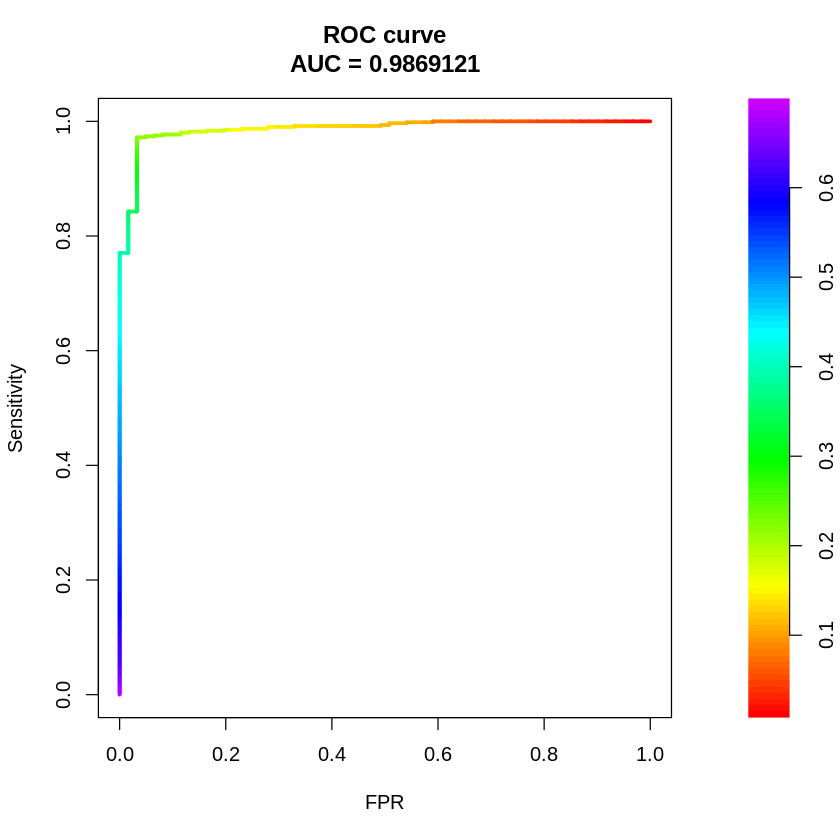

In [ ]:
library("MASS")
library("PRROC")
library(data.table)

data <- fread("http://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt", header = TRUE)
data = as.matrix(data)

X = data[1:700,1:4]
y = data[1:700,5]

d = ncol(X)
n=700
r = 2
N = 100


#Тета_0 - фиксированные параметры
mu_0 = 0
mu_w_0 = 2
lambda_w_0 = 3
gamma_0 = 1
alpha_lambda = 1
beta_lambda = 1

epsilon <-0.01

sigma2 <- epsilon^2/((1+d+d*r+2+2*r)^(1 / 3))
sigma <- sqrt(sigma2)

SaveResults<- matrix(0,N,1+d+d*r+2+2*r)
S<-diag(1+d+d*r+2+2*r)
S1 <- solve(S)

mu_w_new = 0
mu_v_new = rep(0, r)
lambda_w_new = 1
lambda_v_new = rep(1, r)

Theta_0 = 0
Theta_w = rep(0, d)
Theta_v = rep(0, d*r)
Beta = c(Theta_0, Theta_w, Theta_v, lambda_w_new, mu_w_new, lambda_v_new, mu_v_new)

Theta_v_matrix = t(matrix(Theta_v, r, d))

#Функция: логарифм функции правдоподобия
loglik <- function(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X) {

  loglik_1 = sum(y*(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2)))))
  loglik_0 = sum(log(1+exp(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2))))))
  loglik = loglik_1 - loglik_0
  return(loglik)
}

#Функция: логарифм априорного распределения для Theta_H
log_theta_H = function(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new) {

  log_lambda_w = dgamma(Beta_lambda_w_new, shape = alpha_lambda,rate = beta_lambda, log = TRUE)
  log_mu_w = dnorm(Beta_mu_w_new, mu_0, sqrt(1/(gamma_0*Beta_lambda_w_new)), log = TRUE)
  log_lambda_v = sum(dgamma(Beta_lambda_v_new , shape = alpha_lambda,rate = beta_lambda, log = TRUE))
  log_mu_v = sum(dnorm(Beta_mu_v_new, mu_0, sqrt(1/(gamma_0 * Beta_lambda_v_new)), log = TRUE))

  log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
  return(log_theta_H)
}

#Функция: логарифм априорного распределения для Theta
log_theta = function(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new){

  log_theta_0 = dnorm(Beta_Theta_0, mu_w_0, sqrt(1/lambda_w_0), log = TRUE)
  log_theta_w = sum(dnorm(Beta_Theta_w, Beta_mu_w_new, sqrt(1/Beta_lambda_w_new), log = TRUE))
  log_theta_v = sum(dnorm(Beta_v_matrix, Beta_mu_v_new, sqrt(1/Beta_lambda_v_new), log = TRUE))

  log_theta = log_theta_0 + log_theta_w + log_theta_v
  return(log_theta)
}

#Функция: градиент логарифма апостериорного распределения
logpost_grad_function <- function(X,Theta_0, Theta_w, Theta_v_matrix, y, lambda_w_0, mu_w_0, lambda_w_new, mu_w_new, lambda_v_new, mu_v_new,
                                  alpha_lambda, beta_lambda, gamma_0, mu_0){

  doudle_Sum = 0.5 * rowSums((X%*%Theta_v_matrix)^2 - (X^2)%*%(Theta_v_matrix^2))
  ratioexp_old=c(exp(Theta_0 + X%*%Theta_w+doudle_Sum)/(1+exp(Theta_0 + X%*%Theta_w+doudle_Sum)))

  sums_x <- matrix(apply(X, 2, function(q) apply(X, 2, function(o) sum((y-ratioexp_old)*q*o))), nrow = d, ncol = d)

  v_matrix = c(t(t(crossprod(Theta_v_matrix, sums_x)) - Theta_v_matrix * colSums((y-ratioexp_old)*X^2)))

  h <- matrix(c(rep(1, n), X), n, 1 + d)
  h_sum = colSums((y-ratioexp_old)*h)

  grad_loglik = c(h_sum, v_matrix, rep(0, 2+2*r))

  grad_log_theta = c(-lambda_w_0*(Theta_0 - mu_w_0), -lambda_w_new*(Theta_w-mu_w_new), -lambda_v_new*(Theta_v_matrix-mu_v_new),
                          -1/2*sum((Theta_w - mu_w_new)^2)+d/(2*lambda_w_new), lambda_w_new*sum(Theta_w - mu_w_new),
                            -1/2*sum((Theta_v_matrix - mu_v_new)^2)+d/(2*lambda_v_new),  lambda_v_new*sum(Theta_v_matrix - mu_v_new))

  grad_log_theta_H = c(rep(0, 1+d+d*r), (alpha_lambda-1)/lambda_w_new - beta_lambda + 1/(2*lambda_w_new) - gamma_0/2*(mu_w_new - mu_0)^2,
                               -gamma_0*lambda_w_new*(mu_w_new - mu_0), (alpha_lambda-1)/lambda_v_new - beta_lambda + 1/(2*lambda_v_new) - gamma_0/2*(mu_v_new - mu_0)^2,
                                -gamma_0*lambda_v_new*(mu_v_new - mu_0))

  logpost_grad_new = grad_loglik + grad_log_theta+grad_log_theta_H

  return(logpost_grad_new)
}

auroc <- function(score, bool) {
  n1 <- sum(!bool)
  n2 <- sum(bool)
  U  <- sum(rank(score)[!bool]) - n1 * (n1 + 1) / 2
  return(1 - U / n1 / n2)
}

#Градиент логарифма апостериорного распределения
logpost_grad = logpost_grad_function(X, Theta_0, Theta_w, Theta_v_matrix, y, lambda_w_0, mu_w_0, lambda_w_new, mu_w_new,
                                  lambda_v_new, mu_v_new, alpha_lambda, beta_lambda, gamma_0, mu_0)


#Логарифм функции правдоподобия для Beta
loglik_Beta = loglik(Theta_0, Theta_w, Theta_v_matrix, y, X)
# print(loglik_Beta)
#Логарифм априорного распределения для Theta_H для Beta
log_theta_H_Beta = log_theta_H(lambda_w_new, alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
#Логарифм априорного распределения для Theta для Beta
log_theta_Beta = log_theta(Theta_0, mu_w_0, lambda_w_0, Theta_w, mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

#Логарифм апостериорного распределения для Beta
logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta

for(i in 1:N){

  # Proposal distribution for beta
  Beta_new <-  Beta + sigma2/2*logpost_grad + sigma*rnorm(1+d+d*r+2+2*r)

  Beta_Theta_0 = Beta_new[1]
  Beta_Theta_w = Beta_new[2:(d+1)]
  Beta_Theta_v = Beta_new[(d+2):(d+1+d*r)]
  Beta_v_matrix = t(matrix(Beta_Theta_v, r, d))

  Beta_lambda_w_new = Beta_new[1+d+d*r+1]
  Beta_mu_w_new = Beta_new[1+d+d*r+2]
  Beta_lambda_v_new = Beta_new[(1+d+d*r+3):(1+d+d*r+2+r)]
  Beta_mu_v_new = Beta_new[(1+d+d*r+2+r+1):(1+d+d*r+2+2*r)]

    #Логарифм функции правдоподобия для Beta_new
  loglik_Beta_new = loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X)
  #Логарифм априорного распределения для Theta_H для Beta_new
  log_theta_H_Beta_new = log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new)
  #Логарифм априорного распределения для Theta для Beta_new
  log_theta_Beta_new = log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new)

  #Логарифм апостериорного распределения для Beta_new
  logpost_Beta_new = loglik_Beta_new + log_theta_H_Beta_new + log_theta_Beta_new

  #Градиент логарифма апостериорного распределения для Beta_new
  logpost_grad_new = logpost_grad_function(X, Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, lambda_w_0, mu_w_0, Beta_lambda_w_new,
                                      Beta_mu_w_new, Beta_lambda_v_new, Beta_mu_v_new, alpha_lambda, beta_lambda, gamma_0, mu_0)

  # Вспомогательные распределения
  qold <- -t(Beta - Beta_new - sigma2/2*logpost_grad_new)%*%S1%*%(Beta - Beta_new - sigma2/2*logpost_grad_new )/(2*sigma2)
  qnew <- -t(Beta_new - Beta - sigma2/2*logpost_grad)%*%S1%*%(Beta_new - Beta - sigma2/2*logpost_grad)/(2*sigma2)

  # # Metropolis ratio
  ratio <- (logpost_Beta_new - logpost_Beta + qold - qnew)

  # Accept/reject step
  if(log(runif(1)) < ratio)
  {
    logpost_Beta <- logpost_Beta_new
    logpost_grad <- logpost_grad_new
    Beta <- Beta_new
  }
  # Saving results
  SaveResults[i,] <- Beta
}

b_1 <- colMeans(SaveResults)
V = matrix(b_1[(d+2):(d+1+d*r)],d,r,byrow=TRUE)

X1 = data[701:1371,1:4]
y1 = data[701:1371,5]

D = 0.5 * rowSums((X1%*%V)^2 - (X1^2)%*%(V^2))
prob = 1 /(1 + exp(-(b_1[1] + X1 %*%b_1[2:(d+1)] + D)))

auroc(prob,y1)
PRROC_obj <- roc.curve(scores.class0 = prob, weights.class0=y1,
                       curve=TRUE)
plot(PRROC_obj)